# **Regression using bagging on decision trees (v. 2, with more graphs)**

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
class Node:
    def __init__(
        self,
        split_feature_index=None,
        split_treshhold=None,
        left_subtree=None,
        right_subtree=None,
        node_variance_reduction=None,
        leaf_node_value=None,
    ):
        """This class is simply a collection of data that the top of the decision tree should store."""

        self.split_feature_index = split_feature_index
        self.split_treshhold = split_treshhold
        self.left_subtree = left_subtree
        self.right_subtree = right_subtree
        self.node_variance_reduction = node_variance_reduction

        self.leaf_node_value = leaf_node_value

In [3]:
class Decision_tree_regression:
    def __init__(self, node_min_samples_quant=2, max_depth=2):
        """This is the model class for decision tree regression"""

        self._node_min_samples_quant = node_min_samples_quant
        self._max_depth = max_depth

        self._root = None

    def fit(self, X, Y):
        """This function we need for training the model on the training set"""

        dataset = np.concatenate((X, Y), axis=1, dtype=object)
        self._root = self._build_tree(dataset)

    def _build_tree(self, dataset, current_depth=0):
        """This function we need for building \xd0\xb0 de\xd1\x81ision tree"""

        X = dataset[:, :-1]
        Y = dataset[:, -1]

        (dataset_rows_quant, dataset_features_quant) = X.shape

        if (
            dataset_rows_quant >= self._node_min_samples_quant
            and current_depth <= self._max_depth
        ):
            best_split_values = self._get_best_split(dataset, dataset_features_quant)

            if best_split_values["node_variance_reduction"] > 0:
                left_subtree = self._build_tree(
                    best_split_values["dataset_left_split"], current_depth + 1
                )
                right_subtree = self._build_tree(
                    best_split_values["dataset_right_split"], current_depth + 1
                )

                return Node(
                    best_split_values["split_feature_index"],
                    best_split_values["split_treshhold"],
                    left_subtree,
                    right_subtree,
                    best_split_values["node_variance_reduction"],
                )

        leaf_node_value = self._calculate_leaf_node_value(Y)

        return Node(leaf_node_value=leaf_node_value)

    def _get_best_split(self, dataset, dataset_features_quant):
        """This function finds and makes the best split"""

        max_variance_reduction = -float("inf")
        best_split_values = {}

        for current_split_feature_idx in range(dataset_features_quant):
            possible_treshholds = np.unique(dataset[:, current_split_feature_idx])

            for current_split_treshhold in possible_treshholds:
                (dataset_left_split, dataset_right_split) = self._make_split(
                    dataset, current_split_feature_idx, current_split_treshhold
                )

                if len(dataset_left_split) > 0 and len(dataset_right_split) > 0:
                    current_variance_reduction = self._calculate_variance_reduction(
                        dataset, dataset_left_split, dataset_right_split
                    )

                    if current_variance_reduction > max_variance_reduction:
                        best_split_values["split_feature_index"] = current_split_feature_idx
                        best_split_values["split_treshhold"] = current_split_treshhold
                        best_split_values["dataset_left_split"] = dataset_left_split
                        best_split_values["dataset_right_split"] = dataset_right_split
                        best_split_values["node_variance_reduction"] = current_variance_reduction
                        max_variance_reduction = current_variance_reduction

        return best_split_values

    def _make_split(
        self,
        dataset,
        dataset_split_feature_index,
        dataset_split_treshhold,
    ):
        """This function produces the best sample split"""

        dataset_left_split = np.array(
            [
                row
                for row in dataset
                if row[dataset_split_feature_index] <= dataset_split_treshhold
            ]
        )
        dataset_right_split = np.array(
            [
                row
                for row in dataset
                if row[dataset_split_feature_index] > dataset_split_treshhold
            ]
        )

        return (dataset_left_split, dataset_right_split)

    def _calculate_variance_reduction(
        self,
        dataset,
        dataset_left_split,
        dataset_right_split,
    ):
        """This function calculates the reduction between the variance of the parent
        node and the sum of the variances of the child nodes"""

        dataset_targets = dataset[:, -1]
        dataset_left_split_targets = dataset_left_split[:, -1]
        dataset_right_split_targets = dataset_right_split[:, -1]

        card_dataset_left_split = len(dataset_left_split)
        card_dataset_right_split = len(dataset_right_split)
        card_dataset = len(dataset_targets)

        dataset_left_split_targets_variance = np.var(dataset_left_split_targets)
        dataset_right_split_targets_variance = np.var(dataset_right_split_targets)
        dataset_targets_variance = np.var(dataset_targets)

        dataset_variance = card_dataset * dataset_targets_variance
        split_variance = (
            card_dataset_left_split * dataset_left_split_targets_variance
            + card_dataset_right_split * dataset_right_split_targets_variance
        )

        variance_reduction = dataset_variance - split_variance

        return variance_reduction

    def _calculate_leaf_node_value(self, dataset_targets):
        """This function calculates the value that will be contained in the node if it is a leaf"""

        return np.mean(dataset_targets)

    def predict(self, data):
        """This function predicts the values for the sample that was passed as an argument"""

        predictions = np.array(
            [self._make_prediction(data_sample, self._root) for data_sample in data]
        )

        return predictions

    def _make_prediction(self, sample, current_node):
        """This function predicts a value for a particular sample object"""

        if current_node.leaf_node_value != None:
            return current_node.leaf_node_value
        else:
            feature_value = sample[current_node.split_feature_index]

            if feature_value <= current_node.split_treshhold:
                return self._make_prediction(sample, current_node.left_subtree)
            else:
                return self._make_prediction(sample, current_node.right_subtree)

In [4]:
def function(value):
    return value * np.sin(value)

In [5]:
def generate_data(samples_quant=100, values_from=-10, values_to=10, noise_value=0.1):
    X = np.linspace(-10, 10, samples_quant)
    X = np.sort(X)

    Y = function(X) + np.random.normal(0.0, noise_value, samples_quant)

    X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)

    return X, Y

In [6]:
def make_random_subset(X, Y, subset_size):
    dataset = np.concatenate((X, Y), axis=1)
    dataset_sub = np.array(random.sample(list(dataset), subset_size))

    return dataset_sub[:, :-1].reshape(-1, 1), dataset_sub[:, -1].reshape(-1, 1)

In [7]:
def train_decision_tree_on_random_subset(
    X,
    Y,
    subset_samples_quant=20,
    tree_node_min_samples_quant=2,
    tree_max_depth=2,
):
    sub_X, sub_Y = make_random_subset(X, Y, subset_samples_quant)
    model = Decision_tree_regression(
        node_min_samples_quant=tree_node_min_samples_quant, max_depth=tree_max_depth
    )
    model.fit(sub_X, sub_Y)

    return model, sub_X, sub_Y

In [8]:
X_values_from = -10
X_values_to = 10

X_train, Y_train = generate_data(
    samples_quant=100, values_from=X_values_from, values_to=X_values_to, noise_value=1.2
)
X_test, Y_test = generate_data(
    samples_quant=50, values_from=X_values_from, values_to=X_values_to, noise_value=1.2
)

In [9]:
graph_X_true_function_values = np.linspace(X_values_from, X_values_to, 420)
graph_Y_true_function_valuess = function(graph_X_true_function_values)

graph_X_train_values = X_train
graph_Y_train_values = Y_train

graph_X_test_values = X_test
graph_Y_test_values = Y_test

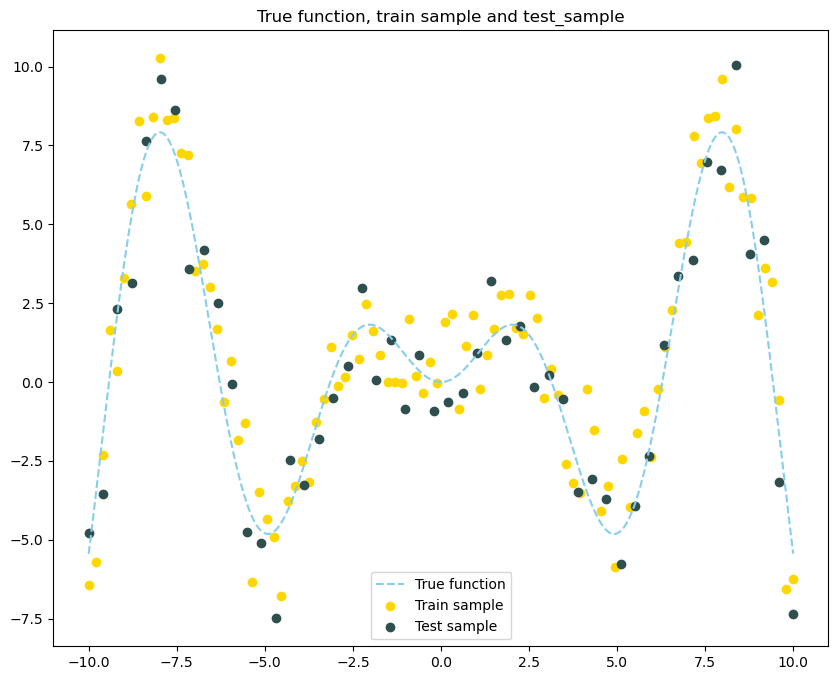

In [10]:
figure, ax = plt.subplots()

figure.set_figwidth(10)
figure.set_figheight(8)

ax.set_title("True function, train sample and test_sample")

ax.plot(
    graph_X_true_function_values,
    graph_Y_true_function_valuess,
    color="skyblue",
    label="True function",
    linestyle="--",
)
ax.scatter(
    graph_X_train_values, graph_Y_train_values, color="gold", label="Train sample"
)
ax.scatter(
    graph_X_test_values, graph_Y_test_values, color="darkslategray", label="Test sample"
)

ax.legend()

plt.show()

Let's train decision trees with max_deth=9 100 times on different subsets of our sample and display the result of each of the 100 trainings. We will do the same, but we will train 100 times bagging on 10 decision trees, depth 9

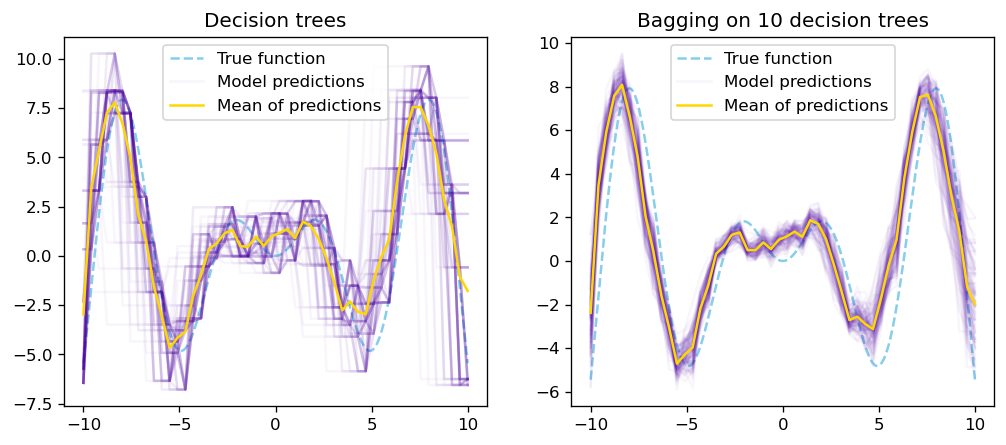

In [11]:
figure, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

# Decision trees predicts graph
ax[0].plot(
    graph_X_true_function_values,
    graph_Y_true_function_valuess,
    color="skyblue",
    label="True function",
    linestyle="--",
)

predictions = []

# Decision trees training and predictions
for i in range(100):
    model, _, _ = train_decision_tree_on_random_subset(
        X_train,
        Y_train,
        subset_samples_quant=30,
        tree_node_min_samples_quant=2,
        tree_max_depth=9,
    )

    prediction = model.predict(X_test)
    predictions.append(prediction)

    if i == 0:
        ax[0].plot(
            graph_X_test_values,
            prediction,
            label="Model predictions",
            color="#5002A7",
            alpha=0.04,
        )
    else:
        ax[0].plot(graph_X_test_values, prediction, color="#5002A7", alpha=0.04)

ax[0].plot(
    graph_X_test_values,
    np.mean(np.stack(predictions), axis=0),
    color="gold",
    label="Mean of predictions",
)
ax[0].set_title("Decision trees")
ax[0].legend()

# Bagging on 10 decision trees predicts graph
ax[1].plot(
    graph_X_true_function_values,
    graph_Y_true_function_valuess,
    color="skyblue",
    label="True function",
    linestyle="--",
)

predictions = []

# Bagging on 10 decision trees training and predictions
for i in range(100):
    prediction = []

    for j in range(10):
        model, _, _ = train_decision_tree_on_random_subset(
            X_train,
            Y_train,
            subset_samples_quant=30,
            tree_node_min_samples_quant=2,
            tree_max_depth=9,
        )

        prediction.append(model.predict(X_test))

    prediction = np.mean(prediction, axis=0)
    predictions.append(prediction)
    if i == 0:
        ax[1].plot(
            graph_X_test_values,
            prediction,
            label="Model predictions",
            color="#5002A7",
            alpha=0.04,
        )
    else:
        ax[1].plot(graph_X_test_values, prediction, color="#5002A7", alpha=0.04)

ax[1].plot(
    graph_X_test_values,
    np.mean(np.stack(predictions), axis=0),
    color="gold",
    label="Mean of predictions",
)
ax[1].set_title("Bagging on 10 decision trees")
ax[1].legend()

plt.show()

As we have seen, bagging is very good at reducing the variance of predictions compared to independent decision trees. However, the bias for both models is almost the same.